In [65]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time
from tqdm import tqdm_notebook
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

"""
Name: feature_extract
Input: String name of file to analyze
Returns: 
Array of:
    y_harmonic
    y_percussive 
    chroma_cens 
    mfcc
    mel_spec
    spec_contrast
Note: 
    MFCC and Chroma_cens are arrays of 12
    Mel_spec and spec_contrast are also closed.
"""
def feature_extract(file):
    y, sr = librosa.load(file, sr=None)
    
    hop_length = 512
    
    # Separate harmonics and percussives into two waveforms
    y_harmonic, y_percussive = librosa.effects.hpss(y)    
    
    #Chroma Energy Normalized (CENS)
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    
    #Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=12, 
                                                 fmax = 8000)
    #Mel-Frequency Cepstral Coefficients (MFCC) features from the raw signal
    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)
    
    #Spectral Contrast
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    
    y_harmonic = np.mean(y_harmonic)
    y_percussive = np.mean(y_percussive)
    mel_spec = np.mean(mel_spec, axis=1)
    mfcc = np.mean(mfcc, axis=1)
    chroma_cens = np.mean(chroma_cens,axis=1)
    spec_contrast = np.mean(spec_contrast, axis=1)
    
    return [y_harmonic, y_percussive, chroma_cens, mfcc, mel_spec, 
            spec_contrast]

"""
Name: get_dataset
Input: 
    data_group: Train, valid, test set name
    source: Acoustic, electronic, synthetic
    class1: First instrument to classify
    class2: second instrument to classify
Returns: 
Array of:
    y_harmonic
    y_percussive 
    mel_spec
    mfcc_0-12
    chroma_0-12
    spec_contrast
"""
def get_dataset(dataGroup, source, class1, class2):#, instrument, source):
    
    new_dir='Dataset/nsynth-'+dataGroup+'/audio/'     #set the audio directory (test, train, etc)
    dataframe_raw = pd.read_json(path_or_buf='Dataset/nsynth-'+dataGroup+'/examples.json', orient='index') #read all instruments from examples.json
    dataframe_specific = dataframe_raw.loc[(dataframe_raw['instrument_family_str'] == class2) | (dataframe_raw['instrument_family_str'] == class2)]           #narrow down by family (strings, etc)
    dataframe_specific = dataframe_specific.loc[dataframe_specific['instrument_source_str'] == source]     #narrow down by source (acoustic, etc)

   
    Y_target_class = dataframe_specific.instrument_family_str.replace(to_replace=[class2, class1], value=[0, 1])
    filenames = dataframe_specific.index.tolist()     #get filenames from our dataframe, put into list
    
    dictionary = {}
    #Create the dictionary of files.
    #Note: TQDM is a loading bar
    for file in tqdm_notebook(filenames):           
        features = feature_extract((new_dir+file+'.wav'))
        dictionary[file] = features
    
    featureDf = pd.DataFrame.from_dict(dictionary, orient='index',
                                       columns=['y_harmonic', 'y_percussive', 'chroma_cens', 
                                                'mfcc', 'mel_spec', 'spec_contrast'])
    
    #Take averages of each coefficient etc and create their own feature
    mel_spec_data = pd.DataFrame(featureDf.mel_spec.values.tolist(), 
                                 index=featureDf.index)
    mel_spec_data = mel_spec_data.add_prefix('Mel_Spec_')
    
    mfcc_data = pd.DataFrame(featureDf.mfcc.values.tolist(), 
                             index=featureDf.index)
    mfcc_data = mfcc_data.add_prefix('MFCC_')
    
    chroma_data = pd.DataFrame(featureDf.chroma_cens.values.tolist(), 
                               index=featureDf.index)
    chroma_data = chroma_data.add_prefix('Chroma_')
    
    spec_contrast_data = pd.DataFrame(featureDf.spec_contrast.values.tolist(), 
                                      index=featureDf.index)
    spec_contrast_data = spec_contrast_data.add_prefix('Spec_Contrast_')
    
    #Drop the old feature columns
    featureDf = featureDf.drop(
        labels=['mel_spec', 'mfcc',
                'chroma_cens', 'spec_contrast'],
                                       axis=1)
    #Add the extracted features
    featureDf = pd.concat([featureDf, mel_spec_data, mfcc_data, 
                           chroma_data, spec_contrast_data],
                         axis = 1, join='inner')
    
    qualities =  pd.DataFrame(dataframe_specific.qualities.values.tolist(), 
                         index = dataframe_specific.index)
    qualities = qualities.add_prefix('NSynth_Quality_')
    dataframe_specific = dataframe_specific.drop(labels=['instrument', 'instrument_family',
                                                          'instrument_family_str', 'instrument_source',
                                                          'instrument_source_str', 'instrument_str',
                                                          'note', 'note_str', 'pitch',
                                                          'qualities_str', 'sample_rate',
                                                         'qualities'], axis=1)
    dataframe_specific = dataframe_specific.drop(dataframe_specific.columns[0], axis=1)
    featureFinal = pd.concat([dataframe_specific, featureDf, qualities], axis=1, sort=False)
    featureFinal['target'] = Y_target_class
    featureFinal.to_csv('./'+dataGroup+'.csv')
    
    #returns dataframe of features
    return featureFinal 

"""
Name: equalize_data
Input: 
    class1: Data in class1
    class2: Data in class2
Returns: 
    equalized data from training
"""
def equalize_data(class1, class2):
    class1_copy = class1
    class2_copy = class2  
    if (class1_copy['y_harmonic'].count() < class2_copy['y_harmonic'].count()):
        while (class1_copy['y_harmonic'].count()<class2_copy['y_harmonic'].count()): 
            temp = [class1_copy, class1]
            class2_copy = pd.concat(temp)
        class2_copy = class2_copy[:class1_copy['y_harmonic'].count()]
    else:
        while (class2_copy['y_harmonic'].count()<class1_copy['y_harmonic'].count()):
            temp = [class2_copy, class2]
            class2_copy = pd.concat(temp)
        class2_copy = class2_copy[:class1_copy['y_harmonic'].count()]
    return (pd.concat([class1_copy, class2_copy]))

def count_errors(predictions):
    count = 0;
    for pred in predictions:
        if (pred[0] != pred[1]):
            count += 1
    return count;

print('functions declared')

functions declared


In [66]:
CLASS_NAMES=['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'synth_lead', 'vocal']

SOURCE_NAMES=['acoustic', 'electronic', 'synthetic']
DATA_GROUPS=['test', 'valid', 'train']
# get string members from dataset
df_test = get_dataset('test', 'acoustic', 'keyboard','string')
# get string members from dataset
df_valid = get_dataset('valid', 'acoustic', 'keyboard','string')

c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\ipykernel_launcher.py:91: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


PermissionError: [Errno 13] Permission denied: './test.csv'

In [54]:
# balance the datasets
#(string_df_test, keyboard_df_test) = equalize_data(string_df_test, keyboard_df_test)
# adding targets to dataframes
#string_df_test['target'] = 0
#keyboard_df_test['target'] = 1

input_df_test = equalize_data(df_test[df_test['target'] == 0], df_test[df_test['target'] == 0])
input_df_valid = equalize_data(df_valid[df_valid['target'] == 0], df_valid[df_valid['target'] == 0])


# (string_df_valid, keyboard_df_valid) = equalize_data(string_df_valid, keyboard_df_valid)
# string_df_valid['target'] = 0
# keyboard_df_valid['target'] = 1
# input_df_valid = pd.concat([string_df_valid, keyboard_df_valid])


# # randomize datasets
input_df_test = input_df_test.sample(frac=1).reset_index(drop=True)
input_df_valid = input_df_valid.sample(frac=1).reset_index(drop=True)


# # encoding target as 0 for keyboard, 1 for string
y_test = input_df_test['target']
x_test = input_df_test.drop(labels=['target', ], axis=1)


# # encoding target as 0 for keyboard, 1 for string
y_valid = input_df_valid['target']
x_valid = input_df_valid.drop(labels=['target'], axis=1)

data_length_test = len(x_test)
data_length_valid = len(x_valid)


In [60]:
def simple_decision_tree(max_depth):
    # hyperparameters
    # max_depth of 4 seems to work well for training with validation set

    # create a scikit-learn tree based on validation set
    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    clf = clf.fit(x_valid, y_valid)

    # make predictions
    predictions_test = np.vstack((y_test, clf.predict(x_test).tolist())).T
    predictions_valid = np.vstack((y_valid, clf.predict(x_valid).tolist())).T

    num_errors_test = count_errors(predictions_test)
    num_errors_valid = count_errors(predictions_valid)

    # calculating valid and test error to two decimal places
    validErrorPercentage = round(num_errors_valid / data_length_valid * 100, 2);
    testErrorPercentage = round(num_errors_test / data_length_test * 100, 2)

    errorLabels = ('Validation Set Error', 'Test Set Error')
    plt.figure(0)
    plt.title("Error in Validation vs Test")
    plt.ylabel("Error (%)")
    plt.bar('Valid', validErrorPercentage)
    plt.bar('Test', testErrorPercentage)

    print('Validation set error percentage: ', validErrorPercentage)
    print('Test set error percentage: ', testErrorPercentage)


Validation set error percentage:  0.0
Test set error percentage:  0.0


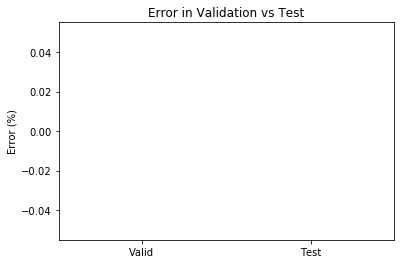

In [61]:
# fit a tree to our data and plot error
simple_decision_tree(4)

In [57]:
def ada_boost(estimators):
    classifier = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1),
        n_estimators=estimators
    )
    classifier.fit(x_valid, y_valid)
    predictions_test = classifier.predict(x_test)
    results_test = confusion_matrix(y_test, predictions_test)
    predictions_valid = classifier.predict(x_valid)
    results_valid = confusion_matrix(y_valid, predictions_valid)
    num_errors_test = results_test[0][1] + results_test[1][0]
    num_errors_valid = results_valid[0][1] + results_valid[1][0]
    
    # calculating valid and test error to two decimal places
    data_length_test = len(predictions_test)
    data_length_valid = len(predictions_valid)
    validErrorPercentage = round(num_errors_valid / data_length_valid * 100, 2);
    testErrorPercentage = round(num_errors_test / data_length_test * 100, 2)

    errorLabels = ('Validation Set Error', 'Test Set Error')
    plt.figure(0)
    plt.title("Error in Validation vs Test")
    plt.ylabel("Error (%)")
    plt.bar('Valid', validErrorPercentage)
    plt.bar('Test', testErrorPercentage)

    print('Validation set error percentage: ', validErrorPercentage)
    print('Test set error percentage: ', testErrorPercentage)

In [51]:
ada_boost(50)

[[612]]


IndexError: index 1 is out of bounds for axis 0 with size 1